In [1]:
import sys
import os 
sys.path.append(os.path.dirname(os.getcwd()))
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import itertools
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

from metrics import bootstrap_mrr_at_k, mrr_at_k, hit_rate_at_k, mrr_at_k_per_experiment, hit_rate_at_k_per_experiment
from models import get_pooled_dataset
from settings import DATA_FOLDER
from notebooks.experiment_data import get_experiment_data, split_experiment_train_test_val_data
from features import FEATURES
from catboost import CatBoostRanker

In [2]:
data = get_experiment_data()

users_df size before removing small experiments: 501008 rows
users_df size after removing small experiments: 500953 rows


In [6]:
feature_set = FEATURES.get_subset("creative_14")
train_data, _, test_data = split_experiment_train_test_val_data(data, n_last_test=4, n_last_val=0)
train_df, train_pool, train_group_ids, X_train, y_train = get_pooled_dataset(train_data, cols=feature_set.all, cat_cols=feature_set.categorical, pos_neg_ratio=1)
test_df, test_pool, test_group_ids, X_test, y_test = get_pooled_dataset(test_data, cols=feature_set.all, cat_cols=feature_set.categorical)

### Exploring Feature Correlations: Covariance Matrix and Highly Correlated Feature Pairs


/Users/broniy/miniconda3/envs/eikona/lib/python3.13/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/Users/broniy/miniconda3/envs/eikona/lib/python3.13/site-packages/scipy/stats/_stats_py.py:7409: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/Users/broniy/miniconda3/envs/eikona/lib/python3.13/site-packages/scipy/stats/_stats_py.py:7409: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/Users/broniy/miniconda3/envs/eikona/lib/python3.13/site-packages/scipy/stats/_stats_py.py:7406: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)
/Users/broniy/miniconda3/envs/eikona/lib/python3.13/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/Users/b

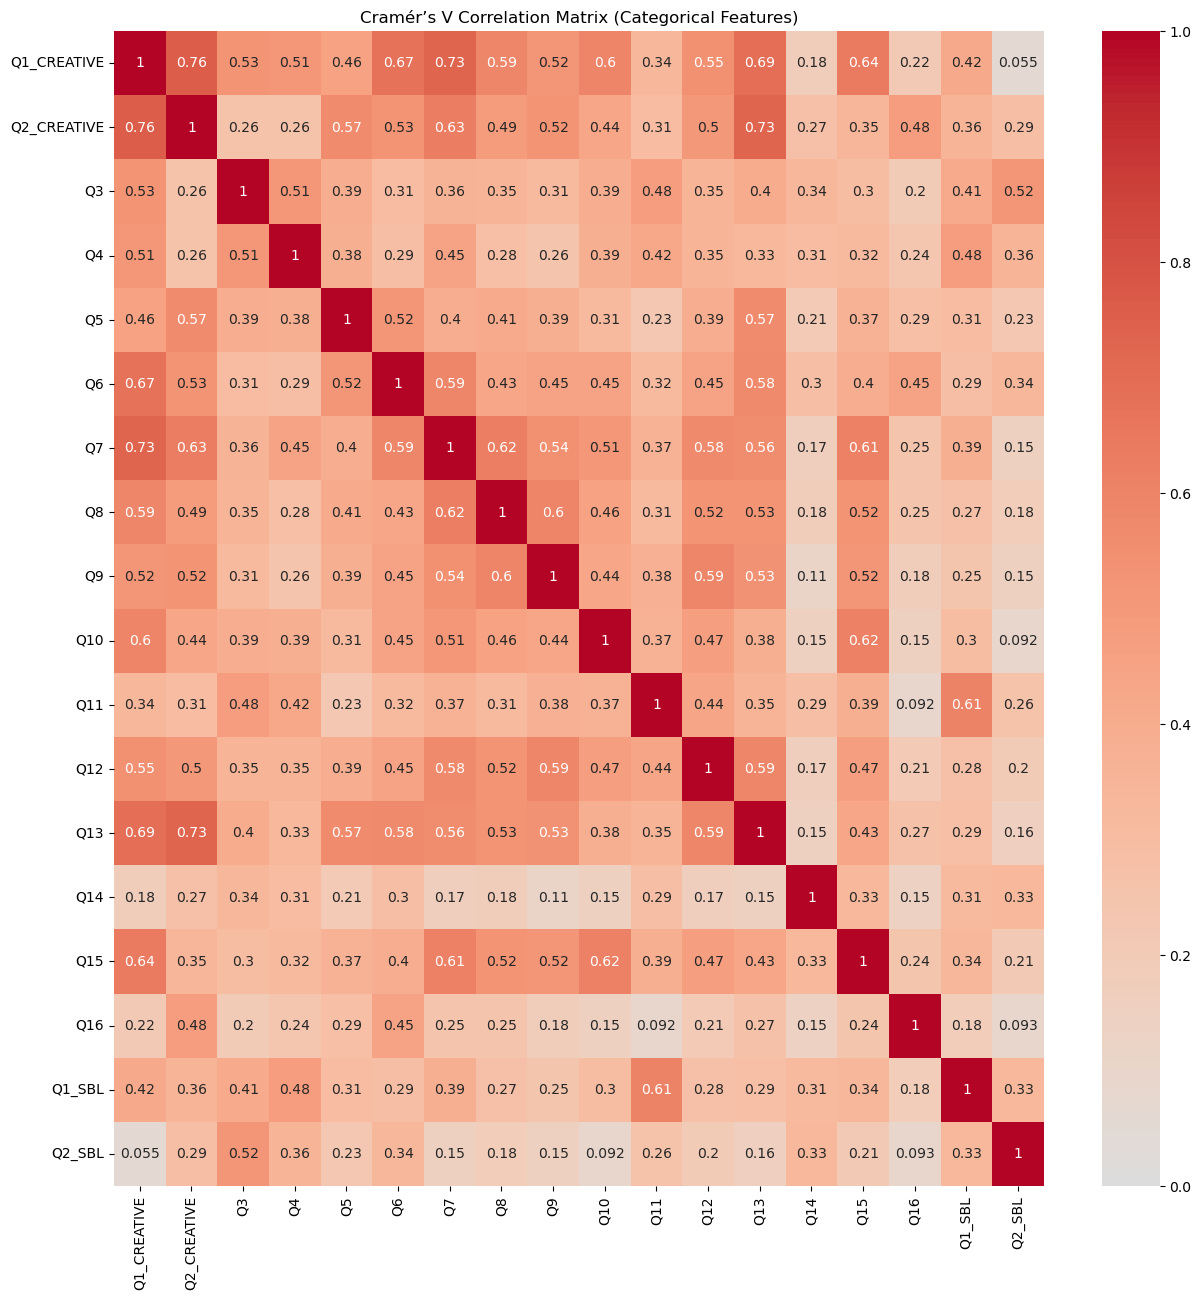

In [13]:
from scipy.stats.contingency import association

feature_set = FEATURES.get_subset("all")
cols = feature_set.categorical
df = data.query("CLICK==1")
n = len(cols)
corr_matrix = pd.DataFrame(np.ones((n, n)), index=cols, columns=cols)
# Compute pairwise Cramér’s V using pingouin
for col1, col2 in itertools.combinations(cols, 2):
        _, _, stats = pg.chi2_independence(df[[col1, col2]].dropna(), x=col1, y=col2)
        v = stats.loc[stats["test"]=="pearson", "cramer"].iat[0]
        corr_matrix.loc[col1, col2] = corr_matrix.loc[col2, col1] = v

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=1)
plt.title("Cramér’s V Correlation Matrix (Categorical Features)")
plt.show()

### Analyzing Feature Importance of the Trained Candidate Model


In [3]:
# Load trained catboost model
ranker = CatBoostRanker()
ranker.load_model("./candidate_production_model.cbm")


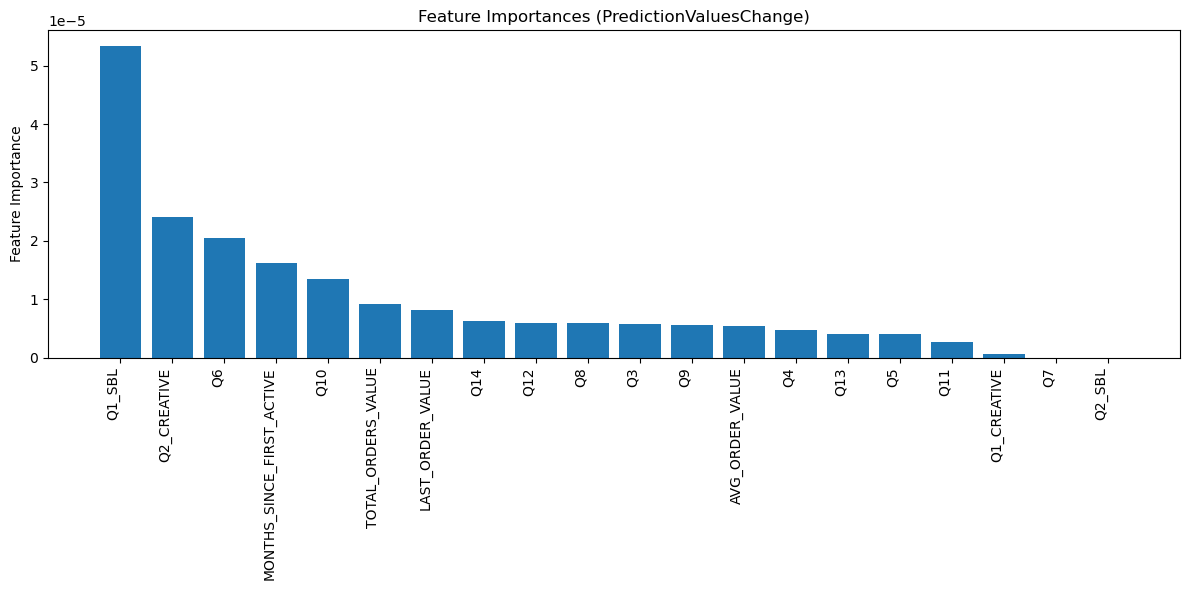

In [8]:
# Get feature importance using PredictionValuesChange method
# This method works better for ranking models and returns one value per feature
# importances = ranker.get_feature_importance(type='PredictionValuesChange')
importances = ranker.get_feature_importance(train_pool, type='LossFunctionChange')

# Create a DataFrame with feature names and their importances
feat_importances = pd.DataFrame({
    'feature': ranker.feature_names_,
    'importance': importances
})

# Sort by importance descending
feat_importances = feat_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feat_importances['feature'], feat_importances['importance'])
plt.xticks(rotation=90, ha='right')
plt.ylabel('Feature Importance')
plt.title('Feature Importances (PredictionValuesChange)')
plt.tight_layout()
plt.show()



### Analysis of Results for the Last 4 Experiments


In [2]:
ranker = CatBoostRanker()
ranker.load_model("./candidate_production_model.cbm")

In [7]:
_, _, test_data = split_experiment_train_test_val_data(
    data, n_last_test=4, n_last_val=0
)
feature_set = FEATURES.get_subset("creative_14")
test_df, test_pool, test_group_ids, X_test, y_test = get_pooled_dataset(
    test_data, cols=feature_set.all, cat_cols=feature_set.categorical
)

In [8]:
scores = ranker.predict(test_pool)
preds = test_df.assign(
    PRED=scores
)[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "PRED"]]
y_true = test_df[
    ["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "CLICK"]
].query("CLICK==1")

result =  pd.merge(preds, y_true, on=["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"], how="left").fillna(0)

In [9]:
last_4_experiments = [
    "823158da-7b0a-4c19-8189-663c22a3ae38",
    "cd4a656f-290a-41e2-be1d-bf62ad85757d",
    "78a802ae-d6cd-4f39-aecb-138668fa2607",
    "0ef6d2e9-7601-4df6-a215-83e6e79aa24e",
]
for i, experiment_id in enumerate(last_4_experiments, start=0):
    print(f"Experiment {4-i}: {experiment_id}")
    preds_experiment = preds.query(f"EXPERIMENT_ID == '{experiment_id}'")
    y_true_experiment = y_true.query(f"EXPERIMENT_ID == '{experiment_id}'")
    print(f"    Hit Rate@1 for experiment {4-i}: {hit_rate_at_k(preds_experiment, y_true_experiment, 1)}")
    print(f"    MRR@5 for experiment {4-i}: {mrr_at_k(preds_experiment, y_true_experiment, 5)}")

Experiment 4: 823158da-7b0a-4c19-8189-663c22a3ae38
    Hit Rate@1 for experiment 4: 0.3293963254593176
    MRR@5 for experiment 4: 0.546026538349373
Experiment 3: cd4a656f-290a-41e2-be1d-bf62ad85757d
    Hit Rate@1 for experiment 3: 0.31152790484903936
    MRR@5 for experiment 3: 0.5398292162244587
Experiment 2: 78a802ae-d6cd-4f39-aecb-138668fa2607
    Hit Rate@1 for experiment 2: 0.31431079894644426
    MRR@5 for experiment 2: 0.5774802458296752
Experiment 1: 0ef6d2e9-7601-4df6-a215-83e6e79aa24e
    Hit Rate@1 for experiment 1: 0.19953596287703015
    MRR@5 for experiment 1: 0.4994844031967001
